In [1]:
import neural_net
import pandas as pd 
import pickle 
import numpy as np
import scipy.optimize as op
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../../fashion-mnist/utils')

import mnist_reader

In [3]:
x_train, y_train = mnist_reader.load_mnist('../../fmnist', kind='train')
x_test, y_test = mnist_reader.load_mnist('../../fmnist', kind='t10k')

In [145]:
# para no estar recargando 
import numpy as np 
import copy 

def sigmoid(values):
    return 1 / (1 + np.exp(-values))

def forward_setup(nodos,X,Y,hidden_layers):
    nodos.insert(0,X.shape[1])
    nodos.append(len(Y[0]))
    nodes = [i + 1 for i in nodos]

    # red, mesh de thetas 
    thetas = []
    # por el momento le voy a poner mas 1 por la output layer 
    for i in range(hidden_layers + 1):
        temp_primero = np.expand_dims(np.asarray([(np.random.randn() / 2) for i in range(nodes[i])],dtype='float64'),1)
        thetas.append(np.matrix(np.asarray(
            [temp_primero for i in range(nodos[i + 1])]
            )))
    return thetas

def forward_prop(X,thetas):
    inicial = X.T      
    trace = [inicial]
    for i in range(len(thetas)):
        interno = np.matmul(
            thetas[i],
            np.vstack(
                [np.expand_dims(np.ones(trace[i].shape[1]),0),
                trace[i]]
                )
        )
        trace.append(sigmoid(interno))
    return trace 

def backward_prop(thetas,shapes,X,Y):
    m,_ = X.shape
    # regresar a su normalidad 
    thetas = unflatten_zetas(thetas,shapes)
    delta = copy.deepcopy(thetas)
    for i in delta: i[:] = 0
    activation_trace = forward_prop(X,thetas)
    first_delta = activation_trace[-1] - Y.T
    deltas = [first_delta]
    # backward prop 
    for i in reversed(range(1,len(thetas))):
        first_delta = np.multiply(
            np.matmul(thetas[i].T[1:,:],first_delta),
            np.multiply(activation_trace[i],(1-activation_trace[i]))
            )
        deltas.append(first_delta)
    deltas.append(None)

    deltas = list(reversed(deltas))
    for i in range(len(delta)):
        temp_shape = activation_trace[i].shape
        multi_res = np.matmul(
            deltas[i + 1],
            np.vstack([np.ones((1,temp_shape[1])),activation_trace[i]]).T
            )
        delta[i] += multi_res / m
    return flatten_zetas(delta)[0]
    
def flatten_zetas(thetas):
    flat_zetas = np.asarray([])
    shapes = []
    for i in thetas:
        shapes.append(i.shape)
        flat_zetas = np.concatenate((flat_zetas,np.ravel(i)))
    return (flat_zetas,shapes)

def unflatten_zetas(flat_thetas,shapes):
    res = []
    for i in shapes:
        cantidad = i[0] * i[1]  
        res.append(flat_thetas[:cantidad].reshape(i))
    return res 

def cost(thetas,shapes,X,Y):
    thetas = unflatten_zetas(thetas,shapes)
    h = forward_prop(X,thetas)[-1]
    calculate = (Y * np.log(h).T) + ((1 - Y) * np.log(1 - h).T)
    print(np.sum(calculate) / (- X.shape[0]))
    return np.sum(calculate) / (- X.shape[0])

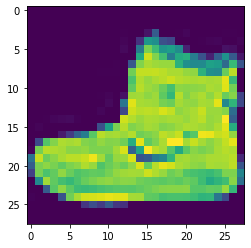

9


In [146]:
# un poco de transformaciones iniciales 
verificacion = plt.imshow(x_train[0].reshape(28,28))
plt.show()
print(y_train[0])
x_train_ingreso = x_train / 1000
x_test_ingreso = x_test / 1000
categorias = 10
y_train_ingreso = (np.expand_dims(y_train,1) == np.arange(categorias)).astype(int)
y_test_ingreso = (np.expand_dims(y_test,1) == np.arange(categorias)).astype(int)

In [147]:
architecture = [2000]
thetas = forward_setup(architecture,x_train_ingreso, y_train_ingreso, len(architecture))
flat_thetas = flatten_zetas(thetas)

In [148]:
start = time.time()

res = op.minimize(
    fun=cost,
    x0=flat_thetas[0],
    args=(flat_thetas[1],x_train_ingreso,y_train_ingreso),
    method='L-BFGS-B',
    jac=backward_prop,
    options={
        'disp':True,
        'maxiter':1300
    }
)

end = time.time()

5.48327163369385
4.210328608958786
5.146287311269138
3.9849143405479985
3.4315240944139878
3.7343389088226577
3.090149761976758
2.908389739030836
2.889517292897274


d:\cs7\env\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in log
d:\cs7\env\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in multiply


nan
3.9950261181199016
3.0469851947064956
2.9772324777710417
3.0036667158115065
2.980585369434039
2.9772324777710417


In [149]:
res

      fun: 2.9772324777710417
 hess_inv: <1590010x1590010 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.90683626e-02, 7.38816334e-08, 8.07710043e-08, ...,
       1.06351865e-02, 1.00218229e-02, 9.64133639e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 16
      nit: 7
   status: 0
  success: True
        x: array([ 0.25417294,  0.37847502,  0.8862653 , ...,  0.03760892,
       -0.4190911 ,  0.07245455])

In [150]:
with open('model.txt', 'wb') as f:
    pickle.dump(res, f)

In [151]:
new_thetas = unflatten_zetas(res.x,flat_thetas[1])
respuestas = forward_prop(x_test_ingreso,new_thetas)

1


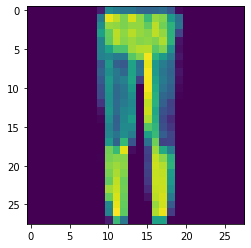

In [152]:
number = 3
prueba = respuestas[-1][:][:,number]
print(np.argmax(prueba))
test = plt.imshow(x_test_ingreso[number].reshape(28,28))
plt.show()

In [153]:
respuestas[-1].T[0]

array([2.56430937e-07, 2.44124446e-10, 3.82012187e-05, 5.24989711e-08,
       3.58370164e-07, 8.29041707e-01, 7.45905269e-08, 8.96860025e-03,
       1.21589523e-04, 7.97969512e-01])

In [154]:
y_pred = np.asarray([np.argmax(i) for i in respuestas[-1].T])

In [155]:
from sklearn import metrics 

metrics.accuracy_score(y_test,y_pred)

0.6707